In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
from statsmodels.formula.api import ols
from scipy.optimize import minimize_scalar

In [2]:
# 自動車データ 
data = pd.read_csv("source/CleanData_20180222.csv", encoding='shift_jis')

# 潜在的な市場規模としての、家計数データ（出所：https://www.airia.or.jp/publish/file/r5c6pv0000006s9v-att/r5c6pv0000006saa.pdf）
dataHH = pd.read_csv("source/HHsize.csv")

# 価格の実質化のための、消費者物価指数（出所：https://www.e-stat.go.jp/stat-search/file-download?statInfId=000031431770&fileKind=1）
dataCPI = pd.read_csv("source/zni2015s.csv", encoding='shift_jis')

# 必要な列のみ抽出・列名の変更
dataCPI = dataCPI[6:56]
dataCPI = dataCPI.rename(columns={'類・品目':'year', '総合':'cpi'})

# 型の変更
dataCPI = dataCPI.astype({'year': 'f2', 'cpi': 'f2'})

# 必要な変数のみ抽出
data = data.loc[:, ['Maker', 'Name', 'Year', 'Sales', 'Model', 'price', 'kata', 'weight', 
                   'FuelEfficiency', 'HorsePower', 'overall_length', 'overall_width','overall_height']]
# 後ほどのマージのために列名の変更
data = data.rename(columns={'Year' : 'year'}) 

# データのマージ
data = pd.merge(data, dataHH,how='left')
data = pd.merge(data, dataCPI,how='left')

# 燃費が欠損しているデータを削除する
#data = data['FuelEfficiency'].dropna()

data = data.dropna()

# 2016年を基準として、価格の実質化を実行する。
# 価格の単位は100万円。

filtered_dataCPI = dataCPI[dataCPI['year'] == 2016]

# 'cpi' 列のみを抽出
cpi2016 = filtered_dataCPI['cpi']

cpi2016 = cpi2016.astype(float)
data['cpi'] = data['cpi'].astype(float)

# 'price' 列を 'cpi' 列と 'cpi2016' 列を用いて変換
# data['cpi']/cpi2016が全てNaNとなり、解決できなかったためコメントアウト。
#data['price'] = data['price'] / (data['cpi'] / cpi2016) 

# 'price' 列を100で割る
data['price'] = data['price'] / 100

# 'cpi' 列を削除
data = data.drop(columns=['cpi'])

# サイズ(高さ＊幅＊長さ)、燃費の重量に対する比率を定義する。
# 'size' 列を追加
data = data.assign(size=lambda x: (x['overall_length'] / 1000) * (x['overall_width'] / 1000) * (x['overall_height'] / 1000))

# 'hppw' 列を追加
data = data.assign(hppw=lambda x: x['HorsePower'] / x['weight'])

# 'HorsePower' と 'weight' 列を削除
data = data.drop(columns=['HorsePower', 'weight'])

# 列名が 'overall' で始まる列を削除
data = data.drop(columns=data.filter(like='overall').columns)

# 自動車の車種IDを作成する。
grouped_data = data.groupby('Name')
data['NameID'] = grouped_data.ngroup()
data = data.reset_index(drop=True)

# 列の順序を変更 (NameID を year の前に移動)
data = data[['NameID', 'year'] + [col for col in data.columns if col not in ['NameID', 'year']]]

# data['HH']から、コンマを消去、int型に変換する。
data['HH'] = data['HH'].str.replace(',', '').astype(int)

# Market ShareとOutside option shareを定義する。
grouped_data = data.groupby('year')
data['inside_total'] = grouped_data['Sales'].transform('sum')

data = data.assign(outside_total = lambda x: x['HH']-x['inside_total'])
data = data.assign(share = data['Sales']/data['HH'])
data = data.assign(share0 = data['outside_total']/data['HH'])
data = data.drop(columns=['inside_total', 'outside_total'])

# BLP操作変数、差別化操作変数（Differentiation IV）
「市場における製品間の競争状況」を捉える変数を操作変数として用いることが多い。

## BLP操作変数（Berry, Levinsohn and Pakes 1995）
### 1.同じ企業が生産している、他の製品の特性（製品品質）の和
$$
    \begin{equation}
    z_{jt}^{BLP, other} = \sum_{k\in J_{ft}\setminus\{j\}} x_{kt}
    \end{equation}
$$
### 2.他の企業が生産している製品の品質の和
$$
    \begin{equation}
    z_{jt}^{BLP, rival} = \sum_{k\notin J_{ft}} x_{kt}
    \end{equation}
$$
  で定義される。ここで、$J_{ft}$は企業$f$がマーケット$t$において販売している財の集合。
  
 これらの変数は、市場における製品間の競争度合いを図っていると考えられる。
 
 
 e.g., 競争相手企業数が多い、かつ、製品数も多い場合、市場競争はより激しくなり価格低下の方向へ寄与すると考えられる。
 
 
 よって、BLP操作変数と価格は相関を持ち、操作変数の関連性の条件を満たすと考えられる。また、独立性についても考える必要がある。
 
 製品品質$x_{jt}$と誤差項$\xi_{jt}$の独立性が満たされている必要がある。これは、製品品質が変化しないと考えられる短期では妥当であるが、長期では、企業は製品品質についても内生的に意思決定すると考えられるため、成立していない可能性が高い。
 
## Differentiation IV (Gandhi and Houde 2020)
 
 競争度合いの指標として、「製品の類似度」を考慮する。同じ企業数、財の種類数であるとしても、対象の財が類似している（$\fallingdotseq$同質財）場合の方が、財が差別化されている場合よりも競争が激しいと考えられる。よって、differentiation IVは以下の2つとして定義される。
 
 ### 1. 同じ企業内の財の属性間の距離
$$
\begin{equation}
z_{jt}^{Quad, other} = \sum_{l\in J_{ft}\setminus \{j\}} d_{jlt}
\end{equation}
$$

### 2. ライバル企業との財の属性間の距離
$$
\begin{equation}
z_{jt}^{Quad, rival} = \sum_{l\notin J_{ft}} d_{jlt}
\end{equation}
$$


ここで、$d_{jlt} = (x_{jt}-x_{lt})^2$は、財$j$と財$l$の間の属性の距離として定義される。


# 実装の方法
- BLP操作変数については定義通り計算する。
- differentiation IVについて

differentiation IVではその距離を操作変数に用いるための工夫をする。[実証ビジネスエコノミクス第２回付録ホームページ](https://www.nippyo.co.jp/blogkeisemi/wp-content/uploads/sites/5/2021/10/code_demand_1.html)を参考に、以下のように考える。

- ある企業$f$が、ある１つのマーケット$t$で、4種類の財を生産。
- 4種類の財の属性をそれぞれA,B,C,Dとする。
- 財1-4について、距離$z_{jt}^{Quad, other} = \sum_{l\in J_{ft}\setminus \{j\}} (x_{jt}-x_{lt})^2$を計算する。
- e.g 財1について距離を考えると、

$$
\begin{equation}
z_{1t}^{Quad, other} = (A-B)^2+(A-C)^2+(A-D)^2 = 3A^2 + (B^2+C^2+D^2)  -2A(B+C+D)
\end{equation}
$$

となる。財$j$の特性を$X$とし、これを一般化すると、

$$
\begin{equation}
z_{jt}^{Quad, other} = (\text{nrow}(\text{data})-1)\times X^2 + (\text{sum}(X^2)-X^2)-2\times X\times (\text{sum}(X)-X)
\end{equation}
$$

となる。これを実装する。

In [3]:
# マーケット・企業レベル（year・Maker）における、各製品属性の和と自乗和を計算する。
data = data.groupby(['year', 'Maker']).apply(lambda x: x.assign(
    hppw_sum_own=x['hppw'].sum(),
    FuelEfficiency_sum_own=x['FuelEfficiency'].sum(),
    size_sum_own=x['size'].sum(),
    hppw_sqr_sum_own=(x['hppw'] ** 2).sum(),
    FuelEfficiency_sqr_sum_own=(x['FuelEfficiency'] ** 2).sum(),
    size_sqr_sum_own=(x['size'] ** 2).sum(),
    group_n = len(x)
)).reset_index(drop=True)

# グループ化を解除
data = data.reset_index(drop=True)

# マーケットレベル（year）での、各製品属性の和を計算。
data = data.groupby('year').apply(lambda x: x.assign(
    hppw_sum_mkt=x['hppw'].sum(),
    FuelEfficiency_sum_mkt=x['FuelEfficiency'].sum(),
    size_sum_mkt=x['size'].sum(),
    hppw_sqr_sum_mkt=(x['hppw'] ** 2).sum(),
    FuelEfficiency_sqr_sum_mkt=(x['FuelEfficiency'] ** 2).sum(),
    size_sqr_sum_mkt=(x['size'] ** 2).sum(),
    mkt_n=len(x)
)).reset_index(drop=True)

# グループ化を解除
data = data.reset_index(drop=True)

# BLP操作変数の構築

data = data.assign(iv_BLP_own_hppw = lambda x: x['hppw_sum_own']-x['hppw'])
data = data.assign(iv_BLP_own_FuelEfficiency = lambda x: x['FuelEfficiency_sum_own']-x['FuelEfficiency'])
data = data.assign(iv_BLP_own_size = lambda x: x['size_sum_own']-x['size'])
data = data.assign(iv_BLP_other_hppw = lambda x: x['hppw_sum_mkt']-x['hppw_sum_own'])
data = data.assign(iv_BLP_other_FuelEfficiency = lambda x: x['FuelEfficiency_sum_mkt']-x['FuelEfficiency_sum_own'])
data = data.assign(iv_BLP_other_size = lambda x: x['size_sum_mkt']-x['size_sum_own'])

/var/folders/gr/21_vqz8x3dgfv42hslwd3cvr0000gn/T/ipykernel_11052/2757473787.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby(['year', 'Maker']).apply(lambda x: x.assign(
/var/folders/gr/21_vqz8x3dgfv42hslwd3cvr0000gn/T/ipykernel_11052/2757473787.py:16: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupb

In [4]:
# Differentiation IVの構築
data = data.assign(iv_GH_own_hppw = lambda x: (x['group_n']-1) * x['hppw']**2 + 
                   (x['hppw_sqr_sum_own']-x['hppw']**2) 
                   - 2*x['hppw']*(x['hppw_sum_own']-x['hppw']))

data = data.assign(iv_GH_own_FuelEfficiency = lambda x: (x['group_n']-1) * x['FuelEfficiency']**2 + 
                   (x['FuelEfficiency_sqr_sum_own']-x['FuelEfficiency']**2) 
                   - 2*x['FuelEfficiency']*(x['FuelEfficiency_sum_own']-x['FuelEfficiency']))

data = data.assign(iv_GH_own_size = lambda x: (x['group_n']-1) * x['size']**2 + 
                   (x['size_sqr_sum_own']-x['size']**2) 
                   - 2*x['size']*(x['size_sum_own']-x['size']))

data = data.assign(iv_GH_other_hppw = lambda x: (x['mkt_n']-x['group_n']) * x['hppw']**2 + 
                   (x['hppw_sqr_sum_mkt']-x['hppw_sqr_sum_own']) 
                   - 2*x['hppw']*(x['hppw_sum_mkt']-x['hppw_sum_own']))

data = data.assign(iv_GH_other_FuelEfficiency = lambda x: (x['mkt_n']-x['group_n']) * x['FuelEfficiency']**2 + 
                   (x['FuelEfficiency_sqr_sum_mkt']-x['FuelEfficiency_sqr_sum_own']) 
                   - 2*x['FuelEfficiency']*(x['FuelEfficiency_sum_mkt']-x['FuelEfficiency_sum_own']))

data = data.assign(iv_GH_other_size = lambda x: (x['mkt_n']-x['group_n']) * x['size']**2 + 
                   (x['size_sqr_sum_mkt']-x['size_sqr_sum_own']) 
                   - 2*x['size']*(x['size_sum_mkt']-x['size_sum_own']))

# 不要な列を削除する
columns_to_remove = [col for col in data.columns if (
    col.startswith("sum_own") or
    col.startswith("sum_mkt") or
    col.startswith("sqr_sum_own") or
    col.startswith("sqr_sum_mkt") or
    col == "mkt_n" or
    col == "group_n"
)]
data = data.drop(columns=columns_to_remove)




In [5]:
# 日評自動車が社内で行った分析について
# 日評自動車を、全車種からランダム選ばれた30車種 を保有する自動車メーカーとする

# 車種のID
IDvec = sorted(data['NameID'].unique())
J = len(IDvec)

# 乱数のseedを固定
np.random.seed(125)
# IDvecから30個のサンプルを非復元抽出して取得
NIPPYOautoIDvec = np.random.choice(IDvec, size=30, replace=False)

# サンプルを昇順にソート
NIPPYOautoIDvec.sort()

# NIPPYOautoIDvecに含まれるIDを持つ行を抽出
data_NIPPYO = data[data['NameID'].isin(NIPPYOautoIDvec)]



# 必要な列を選択
data_NIPPYO = data_NIPPYO[['Sales', 'price', 'hppw', 'FuelEfficiency', 'size']]
# 列 'Sales' と 'price' の対数を計算し、新しい列に追加
data_NIPPYO['log_sales'] = np.log(data_NIPPYO['Sales'])
data_NIPPYO['log_price'] = np.log(data_NIPPYO['price'])

# data_NIPPYO = data_NIPPYO.rename(columns={'log_sales': 'Dependent', 'log_price': 'log_price', 'hppw': 'hppw', 'FuelEfficiency': 'FuelEfficiency', 'size': 'size'})
# 独立変数と従属変数を指定
X = data_NIPPYO[['log_price', 'hppw', 'FuelEfficiency', 'size']]
y = data_NIPPYO['log_sales']

# 定数項（切片）を追加
X = sm.add_constant(X)
data_NIPPYO['price']

# モデルの構築
model = sm.OLS(y, X)
# モデルの適合
results = model.fit()


#results.summary()

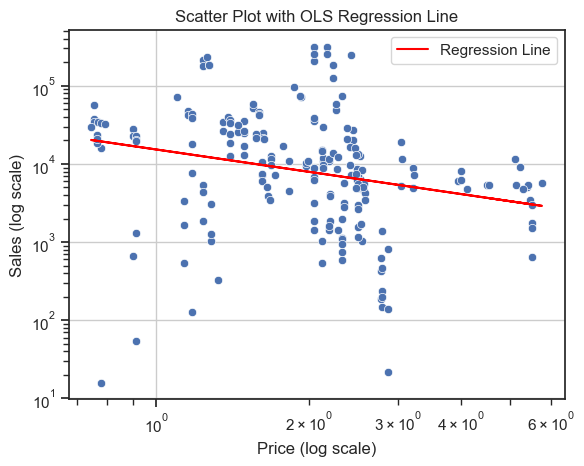

In [6]:
# data_NIPPYOからpriceとSales列を選択
data_graph = data_NIPPYO[['price', 'Sales']]

# 散布図を描画
sns.set(style="ticks")
g1 = sns.scatterplot(x='price', y='Sales', data=data_graph)

# 対数スケールに設定
g1.set(xscale='log', yscale='log')

# OLS回帰モデルの推定
X = np.log(data_graph['price'])  # price列を対数変換
y = np.log(data_graph['Sales'])  # Sales列を対数変換
X = sm.add_constant(X)  # 定数項を追加
model = sm.OLS(y, X).fit()

# 回帰直線の描画
plt.plot(data_graph['price'], np.exp(model.predict(X)), color='red', label='Regression Line')

# グラフの設定
plt.xlabel('Price (log scale)')
plt.ylabel('Sales (log scale)')
plt.title('Scatter Plot with OLS Regression Line')
plt.legend()
plt.grid(True)

# グラフを表示
plt.show()


# Logit Modelの推定
## Settings（離散選択フレームワーク）
- マーケット$t=0,\cdots, T$
- マーケット$t$にある財の数（選択集合）$\{0,\cdots, J_t\}$と購入しないという選択肢（アウトサイドグッズ）
- 潜在的な消費者の数$M_t$
- 消費者$i$がマーケット$t$で財$j$を購入した時の間接効用$U_{ijt}$は

$$
\begin{align*}
U_{ijt}=\left\{
\begin{array}{ll}
\beta^0 + \sum_{k=1}^K\beta^kx_{jt}^k-\alpha p_{jt}+\xi_{jt}+\epsilon_{ijt} & j=1,\cdots, J_t \\
\epsilon_{i0t} & j=0
\end{array}
\right.
\end{align*}
$$

ここで、$\xi_{jt}$は、マーケット$t$の財$j$に特有の、観察されない需要要因。消費者にとっては観察できるが、分析者には観察できない要因を捉えている（e.g., 広告やブランドイメージ）。

$\epsilon_{ijt}$がそれぞれ独立で、第一種極値分布（Gumbel分布）に従うと仮定する。[ここ](https://chief-dollar-d6d.notion.site/3-1-Choice-Probabilities-f8ca8b0df61a456f9539b99f99a453fc)で証明しているように、この時消費者にとっての財$j$を購入する確率は以下の通りになる。

$$
\tag{1}
\text{Pr}(\text{jを購入}) = \frac{\exp(\beta^0 + \sum_{k=1}^K\beta^kx_{jt}^k-\alpha p_{jt}+\xi_{jt})}{1+\sum_{l=1}^{J_t}\exp(\beta^0 + \sum_{k=1}^K\beta^kx_{lt}^k-\alpha p_{lt}+\xi_{lt})}
$$

この確率を全ての消費者について合計することで、マーケット全体の、財$j$に対する需要を計算することができる。つまり、

$$
\tag{2}
q_{jt}(p_{1t},\cdots, p_{J_{t}t}) = M_t\times \text{Pr}(\text{jを購入}) = M_t\frac{\exp(\beta^0 + \sum_{k=1}^K\beta^kx_{jt}^k-\alpha p_{jt}+\xi_{jt})}{1+\sum_{l=1}^{J_t}\exp(\beta^0 + \sum_{k=1}^K\beta^kx_{lt}^k-\alpha p_{lt}+\xi_{lt})}
$$

となる。
## 需要の価格弾力性の計算
(2)式より、需要の価格弾力性を計算する。マーケット$t$における財$j$の市場シェアを$s_{jt}=q_{jt}/M_t$とすると、市場シェアは(1)式そのものになる。 このとき、需要の価格弾力性  $\eta_{jlt}$は、

$$
\begin{align}
\eta_{jlt} = \frac{\partial q_{jt}}{\partial p_{lt}}\frac{p_{lt}}{q_{jt}} = \left\{
\begin{array}{ll}
-\alpha p_{jt}(1-s_{jt}) & l = j \\
\alpha p_{lt}s_{lt} & l \ne j
\end{array}
\right.
\end{align}
$$
となる。

## 集計データを用いたLogit Modelの推定（Berry 1994）

市場シェアを以下のように定義し直す。市場シェアは、アウトサイドグッズのために、潜在的な消費者数に対するシェアとして与えられていることに注意する。
$$
\begin{align}
s_{jt} = \left\{
\begin{array}{ll}
\frac{q_{jt}}{M_t} & j=1,\cdots, J_t\\
\frac{M_t - \sum_{j=1}^{J_t}q_{jt}}{M_t}& j=0
\end{array}
\right.
\end{align}
$$

この市場シェアに、需要関数(2)式を代入することで以下の式を得る。


$$
\tag{3}
\begin{align}
s_{jt} &= \left\{
\begin{array}{ll}
\frac{\exp(\beta^0 + \sum_{k=1}^K\beta^kx_{jt}^k-\alpha p_{jt}+\xi_{jt})}{1+\sum_{l=1}^{J_t}\exp(\beta^0 + \sum_{k=1}^K\beta^kx_{lt}^k-\alpha p_{lt}+\xi_{lt})} & j=1,\cdots, J_t\\
\frac{1}{1+\sum_{l=1}^{J_t}\exp(\beta^0 + \sum_{k=1}^K\beta^kx_{lt}^k-\alpha p_{lt}+\xi_{lt})}& j=0
\end{array}
\right.\\
&=\left\{
\begin{array}{ll}
\frac{\exp(\delta_{jt})}{1+\sum_{l=1}^{J_t}\exp(\delta_{jt})} & j=1,\cdots, J_t\\
\frac{1}{1+\sum_{l=1}^{J_t}\exp(\delta_{jt})} & j=0
\end{array}
\right.
\end{align}
$$

ここで、$\delta_{jt} = \beta^0 + \sum_{k=1}^K\beta^kx_{jt}^k-\alpha p_{jt}+\xi_{jt}$は消費者間で共通であり、これを平均効用という。

このモデルでは、同じマーケット内における消費者間で、財に対する選好が共通であると仮定しているので、市場シェアそのものが選択確率と一致する。

(3)式において、$s_{jt}$を$s_{0t}$の辺々でわり、自然対数を取ると、

$$
\tag{4}
\log \left(\frac{s_{jt}}{s_{0t}}\right) = \delta_{jt}
$$

となる。(4)式は、本来観察することのできない平均効用$\delta_{jt}$を、データから観察できる市場シェアの比率に自然対数をかけたものとして計算できることを意味している。市場シェアのデータから平均効用を導くことをBerryの逆変換という。平均効用の定義から、

$$
\tag{5}
\log s_{jt} - \log s_{0t}  = \beta^0 + \sum_{k=1}^K\beta^kx_{jt}^k-\alpha p_{jt}+\xi_{jt}
$$

を得ることができ、この式はデータから推定することができる。市場シェアの比率の対数値を、価格と財の属性に関するLinear Regressionとしてかける。この式の推定から、需要関数の求めたいパラメータである、$(\alpha, \beta^0, \cdots, \beta^K)$を推定できる。ただし、内生性の問題があるので、推定には操作変数法を用いる必要がある。

In [7]:
# 被説明変数の定義
data['logit_share'] = np.log(data['share']) - np.log(data['share0'])

# OLSの結果
formula_1 = 'logit_share ~ price + hppw + FuelEfficiency + size'
ols = ols(formula_1, data=data).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:            logit_share   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     130.2
Date:                Sat, 09 Sep 2023   Prob (F-statistic):           7.28e-98
Time:                        17:56:47   Log-Likelihood:                -3400.4
No. Observations:                1823   AIC:                             6811.
Df Residuals:                    1818   BIC:                             6838.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -12.2819      0.375    -32.

In [8]:
# BLP操作変数を用いた結果
form_1 = 'logit_share ~ 1 + hppw + FuelEfficiency + size + [price ~ iv_BLP_own_hppw + iv_BLP_own_FuelEfficiency + iv_BLP_own_size + iv_BLP_other_hppw + iv_BLP_other_FuelEfficiency + iv_BLP_other_size]'
mod_1 = IV2SLS.from_formula(form_1, data=data)
iv_BLP = mod_1.fit(cov_type='unadjusted')
print(iv_BLP.summary.tables[1])

                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
Intercept         -12.424     0.4199    -29.589     0.0000     -13.246     -11.601
hppw               1.1773     2.7826     0.4231     0.6722     -4.2764      6.6311
FuelEfficiency     0.1302     0.0094     13.916     0.0000      0.1119      0.1485
size               0.1939     0.0242     8.0075     0.0000      0.1464      0.2413
price             -0.3206     0.0832    -3.8524     0.0001     -0.4837     -0.1575


In [9]:
# Differentiation IVを用いた結果
formula = 'logit_share ~1+ hppw + FuelEfficiency + size + [price ~ iv_GH_own_hppw + iv_GH_own_FuelEfficiency + iv_GH_own_size +iv_GH_other_hppw + iv_GH_other_FuelEfficiency + iv_GH_other_size]'
mod_1 = IV2SLS.from_formula(formula, data=data)
iv_GH = mod_1.fit(cov_type='unadjusted')
print(iv_GH.summary.tables[1])

                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
Intercept         -13.007     0.4242    -30.662     0.0000     -13.838     -12.176
hppw               8.3326     2.7149     3.0691     0.0021      3.0114      13.654
FuelEfficiency     0.1282     0.0096     13.378     0.0000      0.1094      0.1469
size               0.2371     0.0242     9.7798     0.0000      0.1896      0.2846
price             -0.5587     0.0802    -6.9676     0.0000     -0.7159     -0.4016


In [10]:
# 自己価格弾力性の計算
data['own_elas_ols'] = ols.params['price']*data['price']*(1-data['share'])
data['own_elas_ivblp'] = iv_BLP.params['price']*data['price']*(1-data['share'])
data['own_elas_ivgh'] = iv_GH.params['price']*data['price']*(1-data['share'])

data_elas = pd.DataFrame([data['own_elas_ols'],data['own_elas_ivblp'], data['own_elas_ivgh']])

data_elas = data_elas.transpose()

own_elas_columns = data_elas.filter(like='own_elas')
summary = own_elas_columns.describe()
summary = summary.loc[['mean', 'std', '50%', 'min', 'max']]
summary = summary.transpose()
#　結果のレポート
print(summary)

                    mean       std       50%       min       max
own_elas_ols   -0.650388  0.470708 -0.523609 -3.294229 -0.180553
own_elas_ivblp -0.793521  0.574298 -0.638843 -4.019205 -0.220289
own_elas_ivgh  -1.383129  1.001017 -1.113519 -7.005579 -0.383969


In [11]:
# 需要曲線と収入曲線を書く
selected_columns = ['NameID', 'year', 'Sales', 'price', 'FuelEfficiency', 'size', 'hppw', 'HH', 'share']

dt_application = data[selected_columns]
# 'xi_fit' 列を計算
# dt_application['xi_fit'] = iv_GH.resids
data['xi_fit'] = iv_GH.resids

## 需要曲線と収入曲線を書くとき
以下の手順で需要曲線を得る。
1. 推定結果から$\xi_{jt}$を抽出する。
2. 関数を作成する。
3. どこか市場を固定する。ここでは、yearを2016年で固定する。
4. 製品を一つ固定する。
5. その製品の価格を変えたときに、どの製品のSalesがどう変わるかをPredictする。その際、他の製品価格はデータのものに固定しておく。

In [12]:
# 日評自動車が販売する中での特定の車種に着目する。例として、NameID = 87, 
NameID_target = 16
modelID_target = NameID_target
Year_target = 2010
# data['temp_price'] = np.where(data['NameID'] == modelID_target, price_cand, data['price'])
# data['price']

In [13]:
def f_share(price_cand, year, modelID_target, dt, estparam):
    # データフレームをコピー
    dt_result = dt.copy()

    # yearが2010の行をフィルタリング
    dt_result = dt_result[dt_result['year'] == 2010]
    # NameIDがmodelID_targetと一致するものに絞り込み
    dt_result = dt_result[(dt_result['NameID'] == modelID_target)]
    
    # temp_price列を作成
    dt_result['temp_price'] = np.where(dt_result['NameID'] == modelID_target, price_cand, dt_result['price'])
   # print("dt_result['temp_price'] = ",dt_result['temp_price'] )
    # deltaを計算
    dt_result['delta'] = (estparam[0] +
                              estparam[1] * dt_result['hppw']  +
                              estparam[2] * dt_result['FuelEfficiency']+
                              estparam[3] *  dt_result['size'] +
                              estparam[4] * dt_result['temp_price']+
                              dt_result['xi_fit'])
    #print("dt_result['delta'] = ",dt_result['delta'] )
    # denomを計算
    dt_result['denom'] = 1 + np.sum(np.exp(dt_result['delta']))
    #print("denom = ",dt_result['denom'] )
    # pred_salesを計算
    dt_result['pred_sales'] = np.exp(dt_result['delta']) / dt_result['denom'] * dt_result['HH']
    #print('pred_sales = ', dt_result['pred_sales'])
    # modelID_targetに絞り込み
    #dt_result = dt_result[dt_result['NameID'] == modelID_target]
    
    return dt_result['pred_sales']

In [14]:
estparam = iv_GH.params

# pricevecを作成
start = 0.3
end = 5.05
step = 0.05
pricevec = pd.Series([x for x in range(int(start * 100), int((end + step) * 100), int(step * 100))]) / 100.0

# quantvecとrevenuevecの初期化
quantvec = pd.Series([0.0] * len(pricevec))
revenuevec = pd.Series([0.0] * len(pricevec))

In [15]:
# ループを使用してquantvecとrevenuevecを計算
for i in range(len(pricevec)):
    quantvec[i]  = f_share(price_cand= pricevec[i], year=Year_target, modelID_target=NameID_target, dt=data, estparam=estparam)
    revenuevec[i] = pricevec[i]*quantvec[i]

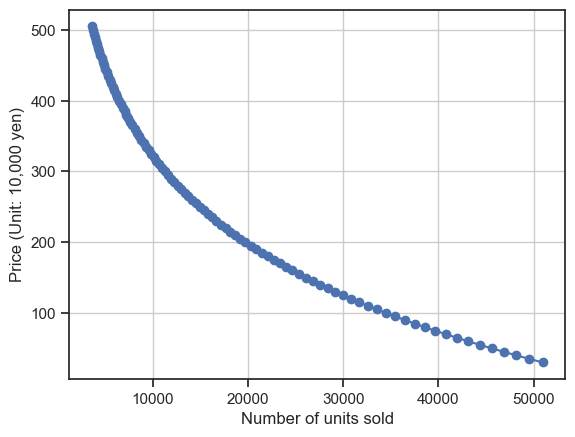

In [16]:
plt.plot(quantvec, [price * 100 for price in pricevec], marker='o')
plt.xlabel("Number of units sold")
plt.ylabel("Price (Unit: 10,000 yen)")
plt.grid(True)

# プロットを表示
plt.show()

/Users/hanazawakaede/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hanazawakaede/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hanazawakaede/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21336 (\N{CJK UNIFIED IDEOGRAPH-5358}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hanazawakaede/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hanazawakaede/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65306 (\N{FUL

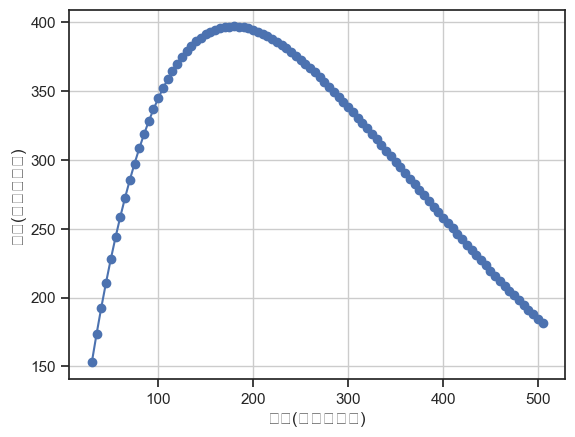

In [17]:
plt.plot([price * 100 for price in pricevec], [revenue * 100 / 10000 for revenue in revenuevec], marker='o', linestyle='-')
plt.xlabel("価格(単位：万円)")
plt.ylabel("収入(単位：億円)")
plt.grid(True)

# プロットを表示
plt.show()